In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy as sp

from scipy import stats
from scipy.special import expit as logistic

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## 1. Beta distribution

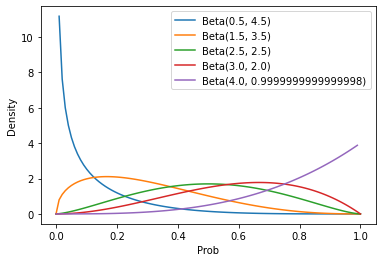

In [ ]:
x = np.linspace(0, 1, 100)
pbars = [0.1, 0.3, 0.5, 0.6, 0.8]
thetas = [5, 5, 5, 5, 5]
for pbar, theta in zip(pbars, thetas):
    y = sp.stats.beta.pdf(x[:, np.newaxis], pbar * theta, (1-pbar) * theta)
    plt.plot(x, y, label=f"Beta({pbar * theta}, {(1 - pbar) * theta})")

plt.xlabel("Prob")
plt.ylabel("Density")
plt.legend();

## 2. UCB admissions

In [ ]:
d = pd.read_csv("./data/UCBadmit.csv", sep=";")
d.shape

(12, 5)

In [ ]:
d.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [ ]:
gid = pd.Categorical(d["applicant.gender"]).codes
N = d["applications"].values

In [ ]:
with pm.Model() as adm1:
    
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    phi = pm.Exponential("phi",1.0)
    theta = pm.Deterministic("theta", 2 + phi)
    
    admit = pm.BetaBinomial("admit", p * theta, (1-p)*theta, N, 
                            observed=d.admit.values)
    
    prior_adm1 = pm.sample_prior_predictive()
    trace_adm1 = pm.sample()
    posterior_adm1 = pm.sample_posterior_predictive(trace_adm1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_adm1, var_names=["a", "phi", "theta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.341,0.423,-1.131,0.466,0.009,0.007,2270.0,1804.0,2277.0,2358.0,1.0
a[1],-0.435,0.413,-1.238,0.306,0.008,0.006,2612.0,2197.0,2619.0,2294.0,1.0
phi,1.054,0.801,0.003,2.443,0.017,0.012,2352.0,2352.0,1984.0,1492.0,1.0
theta,3.054,0.801,2.003,4.443,0.017,0.012,2352.0,2352.0,1984.0,1492.0,1.0


In [ ]:
diff_a = trace_adm1["a"][:, 0] - trace_adm1["a"][:, 1]
diff_p = logistic(trace_adm1["a"][:, 0]) - logistic(trace_adm1["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, 
           kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.09,0.59,-1.05,1.19
diff_p,0.02,0.14,-0.23,0.29


In [ ]:
pp_admit = posterior_adm1["admit"] / N
pp_admit.shape

(4000, 12)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


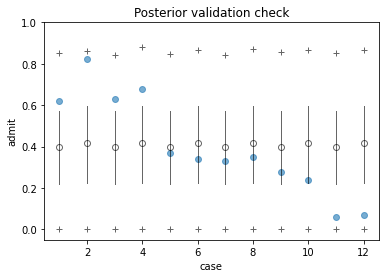

In [ ]:
plt.plot(range(1, 13), d.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), trace_adm1["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_adm1["p"][None, :]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit[None, :]).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);